In [1]:
import os
import io
import shutil
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertAdam, BertForSequenceClassification

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)
from sklearn.utils import resample

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Flatten, SimpleRNN, Dropout, Bidirectional, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tqdm import tqdm, trange

warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS'] = 'ignore'
os.environ['TRANSFORMERS_CACHE'] = 'trans_cache'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
cache = 'trans_cache'
models_path = 'models/first_run/BiomedBERT'


2025-03-17 16:07:33.411173: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 16:07:33.458844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 16:07:33.458876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 16:07:33.460730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 16:07:33.468691: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_set = pd.read_csv('data/manual_curation/train.csv')
test_set = pd.read_csv('data/manual_curation/test.csv')

train_labels = train_set["LABEL"].values
validation_labels = test_set["LABEL"].values

train_sents = train_set["SENTENCE"]
validation_sents = test_set["SENTENCE"]

device = torch.device("cpu")

tokenizer_f = AutoTokenizer.from_pretrained(model_name, cache_dir= cache)

model_f = AutoModel.from_pretrained(model_name, cache_dir= cache)

In [3]:
# setting the max length for padding

In [4]:
max_len = 128

tokenized_train_f = train_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))
tokenized_val_f = validation_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))

padded_train_f = np.array([i + [0]*(max_len-len(i)) if len(i) < max_len else i[:max_len] for i in tokenized_train_f.values])
padded_val_f = np.array([i + [0]*(max_len-len(i)) if len(i) < max_len else i[:max_len] for i in tokenized_val_f.values])

attention_mask_train_f = np.where(padded_train_f != 0, 1, 0)
attention_mask_val_f = np.where(padded_val_f != 0, 1, 0)

input_ids_train_f = torch.tensor(padded_train_f)  
input_ids_val_f = torch.tensor(padded_val_f)  

attention_mask_train_f = torch.tensor(attention_mask_train_f)
attention_mask_val_f = torch.tensor(attention_mask_val_f)

with torch.no_grad():
    last_hidden_states_train = model_f(input_ids_train_f, attention_mask=attention_mask_train_f)
    last_hidden_states_val = model_f(input_ids_val_f, attention_mask=attention_mask_val_f)


features_train = last_hidden_states_train[0][:,0,:].numpy()
features_val= last_hidden_states_val[0][:,0,:].numpy()

train_labels_l = torch.tensor(train_labels).long()
validation_labels_l = torch.tensor(validation_labels).long()

In [5]:
# Logistic Regression

In [6]:

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500, 1000]
}

lr_clf = LogisticRegression(random_state=42)
# Create a pipeline with scaling and logistic regression

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=20, error_score="raise")
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Evaluate the best model on the validation set
best_lr_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_lr_model, models_path + '/lr_model.pkl')

# Load the best model
best_lr_model = joblib.load( models_path + '/lr_model.pkl')

lr_pred = best_lr_model.predict(features_val)

print("Classification report on the validation set:")
print(classification_report(validation_labels_l, lr_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy (Cross-Validation): 0.7962879300508166
Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       322
           1       0.81      0.87      0.84       511

    accuracy                           0.79       833
   macro avg       0.79      0.77      0.78       833
weighted avg       0.79      0.79      0.79       833



In [7]:
# SVM

In [8]:
# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],               
    'gamma': ['scale', 'auto', 0.1, 0.01], 
    'kernel': ['rbf'],                      
    'probability': [True]                  
}

# Initialize the SVM model
svm_clf = SVC(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', n_jobs=20, verbose=1)

# Fit the model using the training data
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Train the best model on the entire training set (optional, since GridSearchCV has already done this)
best_svm_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_svm_model, models_path + '/svm_model.pkl')

# Load the best model
best_svm_model = joblib.load(models_path + '/svm_model.pkl')

# Make predictions using the best model on the validation set
svm_pred = best_svm_model.predict(features_val)

# Print the classification report for the best model
print("Classification report for the best model:")
print(classification_report(validation_labels_l, svm_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
Best Accuracy (Cross-Validation): 0.7970607942257426
Classification report for the best model:
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       322
           1       0.81      0.91      0.85       511

    accuracy                           0.81       833
   macro avg       0.81      0.78      0.79       833
weighted avg       0.81      0.81      0.80       833



In [9]:
# Random Forest

In [10]:
# Define the parameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [50, 100, 200],               
    'max_depth': [None, 10, 20, 30],               
    'min_samples_split': [2, 5, 10],               
    'min_samples_leaf': [1, 2, 4],                 
    'max_features': ['sqrt', 'log2'],     
    'bootstrap': [True, False]                     
}

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=30, verbose=1)

# Fit the model using the training data
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Train the best model on the entire training set (optional, since GridSearchCV has already done this)
best_rf_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_rf_model, models_path + '/rf_model.pkl')

# Load the best model
best_rf_model = joblib.load(models_path + '/rf_model.pkl')

# Make predictions using the best Random Forest model on the validation set
rf_pred = best_rf_model.predict(features_val)

# Print the classification report for the best model
print("Classification report for Random Forest Classifier:")
print(classification_report(validation_labels_l, rf_pred))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy (Cross-Validation): 0.7810943491355863
Classification report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       322
           1       0.78      0.90      0.84       511

    accuracy                           0.79       833
   macro avg       0.79      0.75      0.76       833
weighted avg       0.79      0.79      0.78       833



In [11]:
# reshape features for Deep

In [12]:
train_bert_features = last_hidden_states_train.last_hidden_state
test_bert_features = last_hidden_states_val.last_hidden_state

train_bert_features_reshaped = tf.reshape(train_bert_features, (train_bert_features.shape[0], train_bert_features.shape[1], -1))
test_bert_features_reshaped = tf.reshape(test_bert_features, (test_bert_features.shape[0], test_bert_features.shape[1], -1))

train_bert_features_reshaped = tf.convert_to_tensor(train_bert_features_reshaped, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_bert_features_reshaped = tf.convert_to_tensor(test_bert_features_reshaped, dtype=tf.float32)
validation_labels = tf.convert_to_tensor(validation_labels, dtype=tf.float32)

In [13]:
# LSTM

In [14]:
from tensorflow.keras.optimizers.legacy import Adam

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(train_bert_features_reshaped.shape[1],
                                                                               train_bert_features_reshaped.shape[2]), 
                                                                               dropout=0.3, recurrent_dropout=0.3)))
    model_lstm.add(Bidirectional(LSTM(128, return_sequences=False)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(64, activation='relu'))
    model_lstm.add(Dense(1, activation='sigmoid'))
    model_lstm.compile(metrics=['accuracy'], optimizer=optimizer, loss='binary_crossentropy')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_lstm_fold_' + str(int(fold)) + '.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model_lstm.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_lstm.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_lstm.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_lstm_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_lstm_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_lstm.h5')
best_lstm_model = load_model(models_path + '/model_lstm.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_lstm_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_lstm_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 30s 486ms/step - loss: 0.6141 - accuracy: 0.6703 - val_loss: 0.5448 - val_accuracy: 0.7516
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 21s 428ms/step - loss: 0.5190 - accuracy: 0.7666 - val_loss: 0.4851 - val_accuracy: 0.7786
Epoch 3/20
49/49 [==============================] - 21s 428ms/step - loss: 0.4740 - accuracy: 0.7830 - val_loss: 0.5329 - val_accuracy: 0.7516
Epoch 4/20
49/49 [==============================] - 21s 429ms/step - loss: 0.4545 - accuracy: 0.7952 - val_loss: 0.4860 - val_accuracy: 0.7619
Epoch 5/20
49/49 [==============================] - 21s 434ms/step - loss: 0.4707 - accuracy: 0.7853 - val_loss: 0.4582 - val_accuracy: 0.7838
Epoch 6/20
49/49 [==============================] - 22s 452ms/step - loss: 0.4169 - accuracy: 0.8155 - val_loss: 0.4434 - val_accuracy: 0.8095
Epoch 7/20
49/49 [==============================] - 26s 525ms/step - loss: 0.3767 - accuracy: 0.8342 - val_loss: 0.4158 - val_accuracy: 0.8160
Epoch 8/20
49/49 [==============================] - 26s 525ms/step - loss: 0.3589 - accuracy: 0.8448 - val_loss: 0.4172 - val_accuracy: 0.8069
Epoch 9/20

/tmp/ipykernel_4067061/1908550099.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 34s 546ms/step - loss: 0.6417 - accuracy: 0.6433 - val_loss: 0.5539 - val_accuracy: 0.7336
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 24s 479ms/step - loss: 0.5147 - accuracy: 0.7605 - val_loss: 0.4885 - val_accuracy: 0.7748
Epoch 3/20
49/49 [==============================] - 23s 469ms/step - loss: 0.4796 - accuracy: 0.7856 - val_loss: 0.4751 - val_accuracy: 0.7786
Epoch 4/20
49/49 [==============================] - 23s 461ms/step - loss: 0.4684 - accuracy: 0.7875 - val_loss: 0.4777 - val_accuracy: 0.7683
Epoch 5/20
49/49 [==============================] - 23s 473ms/step - loss: 0.4517 - accuracy: 0.7997 - val_loss: 0.4921 - val_accuracy: 0.7722
Epoch 6/20
49/49 [==============================] - 23s 468ms/step - loss: 0.4339 - accuracy: 0.8091 - val_loss: 0.4835 - val_accuracy: 0.7825
Fold 3:
Epoch 1/20
49/49 [==============================] - 34s 510ms/step - loss: 0.6307 - accuracy: 0.6607 - val_loss: 0.5379 - val_accuracy: 0.7555
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 23s 474ms/step - loss: 0.5214 - accuracy: 0.7701 - val_loss: 0.5304 - val_accuracy: 0.7413
Epoch 3/20
49/49 [==============================] - 23s 466ms/step - loss: 0.4906 - accuracy: 0.7853 - val_loss: 0.4723 - val_accuracy: 0.7851
Epoch 4/20
49/49 [==============================] - 23s 466ms/step - loss: 0.4638 - accuracy: 0.7968 - val_loss: 0.4798 - val_accuracy: 0.7864
Epoch 5/20
49/49 [==============================] - 23s 479ms/step - loss: 0.4448 - accuracy: 0.8100 - val_loss: 0.4718 - val_accuracy: 0.7773
Epoch 6/20
49/49 [==============================] - 24s 480ms/step - loss: 0.4151 - accuracy: 0.8139 - val_loss: 0.4709 - val_accuracy: 0.7928
Epoch 7/20
49/49 [==============================] - 23s 478ms/step - loss: 0.3806 - accuracy: 0.8339 - val_loss: 0.4180 - val_accuracy: 0.8018
Epoch 8/20
49/49 [==============================] - 23s 470ms/step - loss: 0.3464 - accuracy: 0.8545 - val_loss: 0.4195 - val_accuracy: 0.8069
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 30s 477ms/step - loss: 0.6219 - accuracy: 0.6717 - val_loss: 0.5430 - val_accuracy: 0.7526
Epoch 2/20
49/49 [==============================] - 22s 443ms/step - loss: 0.5147 - accuracy: 0.7647 - val_loss: 0.4988 - val_accuracy: 0.7784
Epoch 3/20
49/49 [==============================] - 22s 443ms/step - loss: 0.4829 - accuracy: 0.7805 - val_loss: 0.4874 - val_accuracy: 0.7887
Epoch 4/20
49/49 [==============================] - 22s 459ms/step - loss: 0.4708 - accuracy: 0.7860 - val_loss: 0.4921 - val_accuracy: 0.7848
Epoch 5/20
49/49 [==============================] - 22s 451ms/step - loss: 0.4507 - accuracy: 0.7940 - val_loss: 0.5114 - val_accuracy: 0.7448
Epoch 6/20
49/49 [==============================] - 22s 446ms/step - loss: 0.4387 - accuracy: 0.8024 - val_loss: 0.4717 - val_accuracy: 0.7938
Epoch 7/20
49/49 [==============================] - 22s 445ms/step - loss: 0.4228 - accuracy: 0.8120 - val_loss: 0.4795 - val_accuracy: 0.7925
Epoch 8/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 31s 471ms/step - loss: 0.6255 - accuracy: 0.6695 - val_loss: 0.5614 - val_accuracy: 0.7410
Epoch 2/20
49/49 [==============================] - 22s 449ms/step - loss: 0.5066 - accuracy: 0.7734 - val_loss: 0.5306 - val_accuracy: 0.7410
Epoch 3/20
49/49 [==============================] - 22s 453ms/step - loss: 0.4794 - accuracy: 0.7821 - val_loss: 0.4901 - val_accuracy: 0.7758
Epoch 4/20
49/49 [==============================] - 22s 457ms/step - loss: 0.4724 - accuracy: 0.7863 - val_loss: 0.4841 - val_accuracy: 0.7771
Epoch 5/20
49/49 [==============================] - 22s 448ms/step - loss: 0.4627 - accuracy: 0.7905 - val_loss: 0.5132 - val_accuracy: 0.7564
Epoch 6/20
49/49 [==============================] - 21s 439ms/step - loss: 0.4368 - accuracy: 0.8072 - val_loss: 0.4976 - val_accuracy: 0.7655
Epoch 7/20
49/49 [==============================] - 21s 437ms/step - loss: 0.4149 - accuracy: 0.8172 - val_loss: 0.4741 - val_accuracy: 0.7745
Epoch 8/20

In [15]:
best_lstm_model = load_model(models_path + '/model_lstm.h5')
lstm_pred = np.round(best_lstm_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, lstm_pred))

27/27 [==============================] - 3s 90ms/step
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.79       322
         1.0       0.87      0.85      0.86       511

    accuracy                           0.83       833
   macro avg       0.82      0.83      0.82       833
weighted avg       0.83      0.83      0.83       833



In [16]:
# CNN

In [17]:

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Create the CNN model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', 
                         input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2])))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.3))
    cnn_model.add(Conv1D(256, kernel_size=3, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5)) 
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_cnn_fold_' + str(int(fold)) + '.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = cnn_model.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_cnn.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_cnn.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_cnn_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_cnn_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_cnn.h5')
best_cnn_model = load_model(models_path + '/model_cnn.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_cnn_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_cnn_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 2s 31ms/step - loss: 0.7125 - accuracy: 0.6037 - val_loss: 0.6188 - val_accuracy: 0.6911
Epoch 2/20
 7/49 [===>..........................] - ETA: 0s - loss: 0.5936 - accuracy: 0.6942

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 22ms/step - loss: 0.5558 - accuracy: 0.7399 - val_loss: 0.5381 - val_accuracy: 0.7606
Epoch 3/20
49/49 [==============================] - 1s 21ms/step - loss: 0.5029 - accuracy: 0.7717 - val_loss: 0.5118 - val_accuracy: 0.7709
Epoch 4/20
49/49 [==============================] - 1s 21ms/step - loss: 0.4571 - accuracy: 0.7949 - val_loss: 0.4849 - val_accuracy: 0.7825
Epoch 5/20
49/49 [==============================] - 1s 21ms/step - loss: 0.4206 - accuracy: 0.8210 - val_loss: 0.4507 - val_accuracy: 0.8044
Epoch 6/20
49/49 [==============================] - 1s 21ms/step - loss: 0.3896 - accuracy: 0.8355 - val_loss: 0.4217 - val_accuracy: 0.8211
Epoch 7/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3467 - accuracy: 0.8587 - val_loss: 0.4128 - val_accuracy: 0.8082
Epoch 8/20
49/49 [==============================] - 1s 21ms/step - loss: 0.3308 - accuracy: 0.8670 - val_loss: 0.4316 - val_accuracy: 0.7979
Epoch 9/20
49/49 [======

/tmp/ipykernel_4067061/3587167567.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 2s 32ms/step - loss: 0.7118 - accuracy: 0.5882 - val_loss: 0.6503 - val_accuracy: 0.6036
Epoch 2/20
 7/49 [===>..........................] - ETA: 0s - loss: 0.6090 - accuracy: 0.6205

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 24ms/step - loss: 0.6003 - accuracy: 0.6613 - val_loss: 0.5791 - val_accuracy: 0.7619
Epoch 3/20
49/49 [==============================] - 1s 22ms/step - loss: 0.5350 - accuracy: 0.7382 - val_loss: 0.5089 - val_accuracy: 0.7838
Epoch 4/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4829 - accuracy: 0.7756 - val_loss: 0.4547 - val_accuracy: 0.7954
Epoch 5/20
49/49 [==============================] - 1s 21ms/step - loss: 0.4455 - accuracy: 0.8017 - val_loss: 0.4770 - val_accuracy: 0.7683
Epoch 6/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3996 - accuracy: 0.8232 - val_loss: 0.4392 - val_accuracy: 0.8044
Epoch 7/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3703 - accuracy: 0.8439 - val_loss: 0.4335 - val_accuracy: 0.7992
Epoch 8/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3525 - accuracy: 0.8567 - val_loss: 0.4004 - val_accuracy: 0.8211
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 23ms/step - loss: 0.5435 - accuracy: 0.7408 - val_loss: 0.4884 - val_accuracy: 0.8005
Epoch 3/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4832 - accuracy: 0.7862 - val_loss: 0.4699 - val_accuracy: 0.7864
Epoch 4/20
49/49 [==============================] - 1s 23ms/step - loss: 0.4646 - accuracy: 0.7949 - val_loss: 0.4672 - val_accuracy: 0.8018
Epoch 5/20
49/49 [==============================] - 1s 23ms/step - loss: 0.4306 - accuracy: 0.8104 - val_loss: 0.4184 - val_accuracy: 0.7967
Epoch 6/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3887 - accuracy: 0.8290 - val_loss: 0.3972 - val_accuracy: 0.8417
Epoch 7/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3807 - accuracy: 0.8384 - val_loss: 0.4027 - val_accuracy: 0.8172
Epoch 8/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3308 - accuracy: 0.8699 - val_loss: 0.3928 - val_accuracy: 0.7992
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 22ms/step - loss: 0.5803 - accuracy: 0.7061 - val_loss: 0.5459 - val_accuracy: 0.7771
Epoch 3/20
49/49 [==============================] - 1s 23ms/step - loss: 0.5312 - accuracy: 0.7557 - val_loss: 0.5077 - val_accuracy: 0.7887
Epoch 4/20
49/49 [==============================] - 1s 21ms/step - loss: 0.5037 - accuracy: 0.7609 - val_loss: 0.4960 - val_accuracy: 0.7887
Epoch 5/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4712 - accuracy: 0.7902 - val_loss: 0.4782 - val_accuracy: 0.7964
Epoch 6/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4511 - accuracy: 0.8088 - val_loss: 0.4692 - val_accuracy: 0.7835
Epoch 7/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4127 - accuracy: 0.8220 - val_loss: 0.4305 - val_accuracy: 0.8260
Epoch 8/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3988 - accuracy: 0.8307 - val_loss: 0.4193 - val_accuracy: 0.8260
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 24ms/step - loss: 0.5490 - accuracy: 0.7464 - val_loss: 0.5700 - val_accuracy: 0.7706
Epoch 3/20
49/49 [==============================] - 1s 23ms/step - loss: 0.4934 - accuracy: 0.7721 - val_loss: 0.5642 - val_accuracy: 0.7526
Epoch 4/20
49/49 [==============================] - 1s 24ms/step - loss: 0.4525 - accuracy: 0.7972 - val_loss: 0.5149 - val_accuracy: 0.7732
Epoch 5/20
49/49 [==============================] - 1s 24ms/step - loss: 0.4309 - accuracy: 0.8133 - val_loss: 0.4908 - val_accuracy: 0.7758
Epoch 6/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3977 - accuracy: 0.8194 - val_loss: 0.4965 - val_accuracy: 0.7835
Epoch 7/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3849 - accuracy: 0.8346 - val_loss: 0.4684 - val_accuracy: 0.8003
Epoch 8/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3589 - accuracy: 0.8429 - val_loss: 0.4670 - val_accuracy: 0.7899
Epoch 9/20
49/49 [======

In [18]:
best_cnn_model = load_model(models_path + '/model_cnn.h5')
cnn_pred = np.round(best_cnn_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, cnn_pred))

27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       322
         1.0       0.86      0.89      0.87       511

    accuracy                           0.84       833
   macro avg       0.84      0.83      0.83       833
weighted avg       0.84      0.84      0.84       833



In [19]:
# GRU

In [20]:
num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Create the GRU model
    gru_model = Sequential()
    gru_model.add(Bidirectional(GRU(256, input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2]), 
                                    return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    gru_model.add(Bidirectional(GRU(128, return_sequences=False)))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(64, activation='relu'))
    gru_model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    gru_model.compile(metrics=['accuracy'], optimizer=optimizer, loss='binary_crossentropy')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_gru_fold_' + str(int(fold)) + '.h5', monitor='val_accuracy', save_best_only=True)

    # Train the model
    history = gru_model.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_gru.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_gru.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_gru_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_gru_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_gru.h5')
best_gru_model = load_model(models_path + '/model_gru.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_gru_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_gru_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 29s 449ms/step - loss: 0.6163 - accuracy: 0.6703 - val_loss: 0.5397 - val_accuracy: 0.7323
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 21s 422ms/step - loss: 0.5124 - accuracy: 0.7592 - val_loss: 0.5207 - val_accuracy: 0.7593
Epoch 3/20
49/49 [==============================] - 21s 422ms/step - loss: 0.5018 - accuracy: 0.7653 - val_loss: 0.4700 - val_accuracy: 0.7838
Epoch 4/20
49/49 [==============================] - 21s 423ms/step - loss: 0.4629 - accuracy: 0.7907 - val_loss: 0.4695 - val_accuracy: 0.7979
Epoch 5/20
49/49 [==============================] - 21s 433ms/step - loss: 0.4715 - accuracy: 0.7817 - val_loss: 0.4620 - val_accuracy: 0.7967
Epoch 6/20
49/49 [==============================] - 21s 431ms/step - loss: 0.4637 - accuracy: 0.7872 - val_loss: 0.4539 - val_accuracy: 0.7967
Epoch 7/20
49/49 [==============================] - 21s 432ms/step - loss: 0.4333 - accuracy: 0.8091 - val_loss: 0.4481 - val_accuracy: 0.8018
Epoch 8/20
49/49 [==============================] - 21s 436ms/step - loss: 0.4196 - accuracy: 0.8081 - val_loss: 0.4447 - val_accuracy: 0.7967
Epoch 9/20

/tmp/ipykernel_4067061/2979893419.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 29s 474ms/step - loss: 0.6266 - accuracy: 0.6758 - val_loss: 0.5526 - val_accuracy: 0.7310
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 22s 446ms/step - loss: 0.5283 - accuracy: 0.7601 - val_loss: 0.4944 - val_accuracy: 0.7735
Epoch 3/20
49/49 [==============================] - 21s 434ms/step - loss: 0.4914 - accuracy: 0.7791 - val_loss: 0.4806 - val_accuracy: 0.7825
Epoch 4/20
49/49 [==============================] - 22s 444ms/step - loss: 0.4812 - accuracy: 0.7843 - val_loss: 0.4627 - val_accuracy: 0.7761
Epoch 5/20
49/49 [==============================] - 21s 435ms/step - loss: 0.4539 - accuracy: 0.7959 - val_loss: 0.4602 - val_accuracy: 0.7902
Epoch 6/20
49/49 [==============================] - 21s 438ms/step - loss: 0.4481 - accuracy: 0.7946 - val_loss: 0.4386 - val_accuracy: 0.7967
Epoch 7/20
49/49 [==============================] - 21s 430ms/step - loss: 0.3972 - accuracy: 0.8213 - val_loss: 0.3988 - val_accuracy: 0.8160
Epoch 8/20
49/49 [==============================] - 21s 428ms/step - loss: 0.3811 - accuracy: 0.8371 - val_loss: 0.3884 - val_accuracy: 0.8018
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 21s 436ms/step - loss: 0.5185 - accuracy: 0.7614 - val_loss: 0.4925 - val_accuracy: 0.7580
Epoch 3/20
49/49 [==============================] - 22s 442ms/step - loss: 0.5085 - accuracy: 0.7650 - val_loss: 0.5022 - val_accuracy: 0.7671
Epoch 4/20
49/49 [==============================] - 22s 451ms/step - loss: 0.4872 - accuracy: 0.7788 - val_loss: 0.4862 - val_accuracy: 0.7671
Epoch 5/20
49/49 [==============================] - 22s 438ms/step - loss: 0.4569 - accuracy: 0.7936 - val_loss: 0.4754 - val_accuracy: 0.7799
Epoch 6/20
49/49 [==============================] - 21s 431ms/step - loss: 0.4259 - accuracy: 0.8094 - val_loss: 0.4488 - val_accuracy: 0.7825
Epoch 7/20
49/49 [==============================] - 21s 433ms/step - loss: 0.3934 - accuracy: 0.8236 - val_loss: 0.4264 - val_accuracy: 0.7902
Epoch 8/20
49/49 [==============================] - 22s 441ms/step - loss: 0.3426 - accuracy: 0.8603 - val_loss: 0.4057 - val_accuracy: 0.8224
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 22s 451ms/step - loss: 0.5326 - accuracy: 0.7531 - val_loss: 0.4992 - val_accuracy: 0.7732
Epoch 3/20
49/49 [==============================] - 21s 439ms/step - loss: 0.5057 - accuracy: 0.7676 - val_loss: 0.4914 - val_accuracy: 0.7861
Epoch 4/20
49/49 [==============================] - 21s 431ms/step - loss: 0.4863 - accuracy: 0.7850 - val_loss: 0.5023 - val_accuracy: 0.7706
Epoch 5/20
49/49 [==============================] - 21s 428ms/step - loss: 0.4660 - accuracy: 0.7940 - val_loss: 0.5014 - val_accuracy: 0.7796
Epoch 6/20
49/49 [==============================] - 21s 432ms/step - loss: 0.4383 - accuracy: 0.8098 - val_loss: 0.4752 - val_accuracy: 0.7771
Epoch 7/20
49/49 [==============================] - 21s 428ms/step - loss: 0.4044 - accuracy: 0.8227 - val_loss: 0.4800 - val_accuracy: 0.7784
Epoch 8/20
49/49 [==============================] - 21s 427ms/step - loss: 0.4114 - accuracy: 0.8172 - val_loss: 0.4956 - val_accuracy: 0.7848
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 31s 462ms/step - loss: 0.6690 - accuracy: 0.6608 - val_loss: 0.5230 - val_accuracy: 0.7629
Epoch 2/20
49/49 [==============================] - 21s 437ms/step - loss: 0.5300 - accuracy: 0.7535 - val_loss: 0.4993 - val_accuracy: 0.7796
Epoch 3/20
49/49 [==============================] - 22s 441ms/step - loss: 0.4949 - accuracy: 0.7753 - val_loss: 0.4759 - val_accuracy: 0.7938
Epoch 4/20
49/49 [==============================] - 21s 427ms/step - loss: 0.4779 - accuracy: 0.7895 - val_loss: 0.4690 - val_accuracy: 0.7874
Epoch 5/20
49/49 [==============================] - 21s 436ms/step - loss: 0.4654 - accuracy: 0.7892 - val_loss: 0.4474 - val_accuracy: 0.8054
Epoch 6/20
49/49 [==============================] - 21s 434ms/step - loss: 0.4279 - accuracy: 0.8095 - val_loss: 0.4099 - val_accuracy: 0.8299
Epoch 7/20
49/49 [==============================] - 21s 431ms/step - loss: 0.3907 - accuracy: 0.8297 - val_loss: 0.3917 - val_accuracy: 0.8235
Epoch 8/20

In [21]:
best_gru_model = load_model(models_path + '/model_gru.h5')
gru_probs = best_gru_model.predict(test_bert_features_reshaped)
gru_pred = np.round(best_gru_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, gru_pred))

27/27 [==============================] - 2s 76ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       322
         1.0       0.87      0.89      0.88       511

    accuracy                           0.85       833
   macro avg       0.84      0.84      0.84       833
weighted avg       0.85      0.85      0.85       833



In [22]:
# CNN-LSTM

In [23]:

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Define the CNN-LSTM model
    model_lc = Sequential()
    model_lc.add(Conv1D(filters=256, kernel_size=3, activation='relu',
                        input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2])))
    model_lc.add(MaxPooling1D(pool_size=2))
    model_lc.add(Dropout(0.3))
    model_lc.add(LSTM(units=128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model_lc.add(LSTM(units=64, return_sequences=False, dropout=0.3))
    model_lc.add(Dense(units=64, activation='relu'))
    model_lc.add(Dropout(0.4))
    model_lc.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model_lc.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_cnn_lstm_fold_' + str(fold) + '.h5', monitor='val_accuracy', save_best_only=True)

    # Train the model
    history = model_lc.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=3), model_checkpoint])

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_cnn_lstm.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

losses_df.to_csv(models_path + '/losses_cnn_lstm.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_cnn_lstm_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_cnn_lstm_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_cnn_lstm.h5')
best_lc_model = load_model(models_path + '/model_cnn_lstm.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_lc_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_lc_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 11s 148ms/step - loss: 0.6232 - accuracy: 0.6568 - val_loss: 0.5173 - val_accuracy: 0.7658
Epoch 2/20
 1/49 [..............................] - ETA: 5s - loss: 0.5004 - accuracy: 0.7969

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 103ms/step - loss: 0.5340 - accuracy: 0.7598 - val_loss: 0.5186 - val_accuracy: 0.7555
Epoch 3/20
49/49 [==============================] - 5s 101ms/step - loss: 0.5064 - accuracy: 0.7727 - val_loss: 0.4869 - val_accuracy: 0.7825
Epoch 4/20
49/49 [==============================] - 5s 99ms/step - loss: 0.4767 - accuracy: 0.7885 - val_loss: 0.4795 - val_accuracy: 0.7799
Epoch 5/20
49/49 [==============================] - 5s 105ms/step - loss: 0.4579 - accuracy: 0.7985 - val_loss: 0.4772 - val_accuracy: 0.7954
Epoch 6/20
49/49 [==============================] - 5s 103ms/step - loss: 0.4750 - accuracy: 0.7804 - val_loss: 0.4983 - val_accuracy: 0.7735
Epoch 7/20
49/49 [==============================] - 5s 101ms/step - loss: 0.4314 - accuracy: 0.8142 - val_loss: 0.4757 - val_accuracy: 0.7915
Epoch 8/20
49/49 [==============================] - 5s 103ms/step - loss: 0.4048 - accuracy: 0.8165 - val_loss: 0.4652 - val_accuracy: 0.7799
Epoch 9/20
49/49 [

/tmp/ipykernel_4067061/3257419321.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 9s 121ms/step - loss: 0.6459 - accuracy: 0.6497 - val_loss: 0.6070 - val_accuracy: 0.6988
Epoch 2/20
 1/49 [..............................] - ETA: 4s - loss: 0.6340 - accuracy: 0.6562

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 100ms/step - loss: 0.5494 - accuracy: 0.7508 - val_loss: 0.5168 - val_accuracy: 0.7658
Epoch 3/20
49/49 [==============================] - 5s 104ms/step - loss: 0.5115 - accuracy: 0.7669 - val_loss: 0.4999 - val_accuracy: 0.7696
Epoch 4/20
49/49 [==============================] - 5s 103ms/step - loss: 0.4879 - accuracy: 0.7730 - val_loss: 0.5353 - val_accuracy: 0.7529
Epoch 5/20
49/49 [==============================] - 5s 106ms/step - loss: 0.4676 - accuracy: 0.7904 - val_loss: 0.4674 - val_accuracy: 0.7851
Epoch 6/20
49/49 [==============================] - 5s 103ms/step - loss: 0.4496 - accuracy: 0.7972 - val_loss: 0.4649 - val_accuracy: 0.7786
Epoch 7/20
49/49 [==============================] - 5s 103ms/step - loss: 0.4358 - accuracy: 0.8071 - val_loss: 0.4717 - val_accuracy: 0.7799
Epoch 8/20
49/49 [==============================] - 5s 107ms/step - loss: 0.4082 - accuracy: 0.8242 - val_loss: 0.4431 - val_accuracy: 0.8069
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 109ms/step - loss: 0.5463 - accuracy: 0.7547 - val_loss: 0.5270 - val_accuracy: 0.7375
Epoch 3/20
49/49 [==============================] - 5s 106ms/step - loss: 0.5004 - accuracy: 0.7788 - val_loss: 0.5316 - val_accuracy: 0.7375
Epoch 4/20
49/49 [==============================] - 5s 104ms/step - loss: 0.5091 - accuracy: 0.7743 - val_loss: 0.5203 - val_accuracy: 0.7503
Epoch 5/20
49/49 [==============================] - 5s 104ms/step - loss: 0.4737 - accuracy: 0.7907 - val_loss: 0.4931 - val_accuracy: 0.7658
Epoch 6/20
49/49 [==============================] - 5s 104ms/step - loss: 0.4604 - accuracy: 0.7972 - val_loss: 0.5181 - val_accuracy: 0.7542
Epoch 7/20
49/49 [==============================] - 5s 103ms/step - loss: 0.4482 - accuracy: 0.8071 - val_loss: 0.5094 - val_accuracy: 0.7722
Epoch 8/20
49/49 [==============================] - 5s 104ms/step - loss: 0.4432 - accuracy: 0.8065 - val_loss: 0.4859 - val_accuracy: 0.7671
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 106ms/step - loss: 0.6532 - accuracy: 0.6231 - val_loss: 0.5733 - val_accuracy: 0.7513
Epoch 3/20
49/49 [==============================] - 5s 105ms/step - loss: 0.5594 - accuracy: 0.7473 - val_loss: 0.5175 - val_accuracy: 0.7732
Epoch 4/20
49/49 [==============================] - 5s 105ms/step - loss: 0.5347 - accuracy: 0.7631 - val_loss: 0.5110 - val_accuracy: 0.7616
Epoch 5/20
49/49 [==============================] - 5s 102ms/step - loss: 0.5029 - accuracy: 0.7818 - val_loss: 0.5171 - val_accuracy: 0.7629
Epoch 6/20
49/49 [==============================] - 5s 103ms/step - loss: 0.4819 - accuracy: 0.7818 - val_loss: 0.5018 - val_accuracy: 0.7655
Epoch 7/20
49/49 [==============================] - 5s 108ms/step - loss: 0.4662 - accuracy: 0.7934 - val_loss: 0.5208 - val_accuracy: 0.7564
Epoch 8/20
49/49 [==============================] - 5s 107ms/step - loss: 0.4582 - accuracy: 0.7934 - val_loss: 0.5007 - val_accuracy: 0.7539
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 102ms/step - loss: 0.5627 - accuracy: 0.7477 - val_loss: 0.5525 - val_accuracy: 0.7307
Epoch 3/20
49/49 [==============================] - 5s 109ms/step - loss: 0.5160 - accuracy: 0.7670 - val_loss: 0.4788 - val_accuracy: 0.7784
Epoch 4/20
49/49 [==============================] - 5s 105ms/step - loss: 0.5028 - accuracy: 0.7773 - val_loss: 0.4930 - val_accuracy: 0.7732
Epoch 5/20
49/49 [==============================] - 5s 103ms/step - loss: 0.5011 - accuracy: 0.7692 - val_loss: 0.4798 - val_accuracy: 0.7603
Epoch 6/20
49/49 [==============================] - 5s 100ms/step - loss: 0.4767 - accuracy: 0.7821 - val_loss: 0.4688 - val_accuracy: 0.7732
Epoch 7/20
49/49 [==============================] - 5s 107ms/step - loss: 0.4598 - accuracy: 0.7976 - val_loss: 0.4552 - val_accuracy: 0.7938
Epoch 8/20
49/49 [==============================] - 5s 101ms/step - loss: 0.4497 - accuracy: 0.8037 - val_loss: 0.4469 - val_accuracy: 0.7848
Epoch 9/20
49/49 

In [24]:
best_lc_model = load_model(models_path + '/model_cnn_lstm.h5')
lc_probs = best_lc_model.predict(test_bert_features_reshaped)
lc_pred = np.round(best_lc_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, lc_pred))


27/27 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72       322
         1.0       0.82      0.85      0.83       511

    accuracy                           0.79       833
   macro avg       0.78      0.77      0.77       833
weighted avg       0.79      0.79      0.79       833



In [25]:
lr_probs = best_lr_model.predict_proba(features_val)
svm_probs = best_svm_model.predict_proba(features_val)
rf_probs = best_rf_model.predict_proba(features_val)
cnn_probs = best_cnn_model.predict(test_bert_features_reshaped)
lstm_probs = best_lstm_model.predict(test_bert_features_reshaped)
gru_probs = best_gru_model.predict(test_bert_features_reshaped)
lc_probs = best_lc_model.predict(test_bert_features_reshaped)

27/27 [==============================] - 1s 21ms/step


In [26]:
# ROC curves

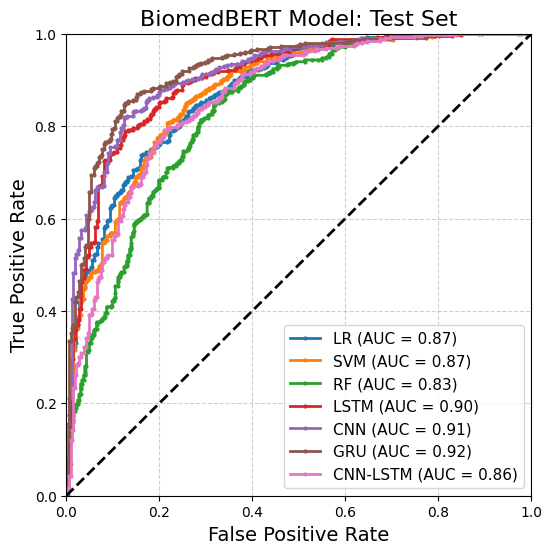

In [27]:
fpr, tpr, _ = roc_curve(validation_labels, lr_probs[:,1])
fpr2, tpr2, _ = roc_curve(validation_labels, svm_probs[:,1])
fpr3, tpr3, _ = roc_curve(validation_labels, rf_probs[:,1])
fpr4, tpr4, _ = roc_curve(validation_labels, lstm_probs)
fpr5, tpr5, _ = roc_curve(validation_labels, cnn_probs)
fpr6, tpr6, _ = roc_curve(validation_labels, gru_probs)
fpr7, tpr7, _ = roc_curve(validation_labels, lc_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)

fprs = [fpr, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7]
tprs = [tpr, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7]
roc_aucs = [roc_auc1, roc_auc2, roc_auc3, roc_auc4, roc_auc5, roc_auc6, roc_auc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))  

for fpr, tpr, roc_auc, label in zip(fprs, tprs, roc_aucs, labels):
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(label, roc_auc), marker='.', markersize=4)  
    
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('BiomedBERT Model: Test Set', fontsize=16)

plt.legend(loc='lower right', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
#AUPRC curves

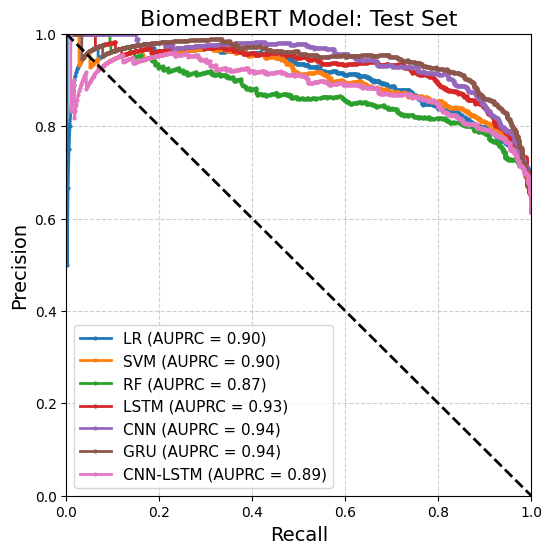

In [29]:
# Compute Precision-Recall curve for each model
precision1, recall1, _ = precision_recall_curve(validation_labels, lr_probs[:, 1])
precision2, recall2, _ = precision_recall_curve(validation_labels, svm_probs[:, 1])
precision3, recall3, _ = precision_recall_curve(validation_labels, rf_probs[:, 1])
precision4, recall4, _ = precision_recall_curve(validation_labels, lstm_probs)
precision5, recall5, _ = precision_recall_curve(validation_labels, cnn_probs)
precision6, recall6, _ = precision_recall_curve(validation_labels, gru_probs)
precision7, recall7, _ = precision_recall_curve(validation_labels, lc_probs)

# Calculate AUPRC
auprc1 = auc(recall1, precision1)
auprc2 = auc(recall2, precision2)
auprc3 = auc(recall3, precision3)
auprc4 = auc(recall4, precision4)
auprc5 = auc(recall5, precision5)
auprc6 = auc(recall6, precision6)
auprc7 = auc(recall7, precision7)

precisions = [precision1, precision2, precision3, precision4, precision5, precision6, precision7]
recalls = [recall1, recall2, recall3, recall4, recall5, recall6, recall7]
auprcs = [auprc1, auprc2, auprc3, auprc4, auprc5, auprc6, auprc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))

for precision, recall, auprc, label in zip(precisions, recalls, auprcs, labels):
    plt.plot(recall, precision, lw=2, label='{} (AUPRC = {:.2f})'.format(label, auprc), marker='.', markersize=4)

plt.plot([0, 1], [1, 0], color='black', linestyle='--', lw=2)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('BiomedBERT Model: Test Set', fontsize=16)

plt.legend(loc='lower left', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/prc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


In [30]:
# data table with score

In [31]:
dfs = []

# List of algorithm names and corresponding predictions
algorithm_names = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']
predictions = [lr_pred, svm_pred, rf_pred, lstm_pred, cnn_pred, gru_pred, lc_pred]

# Iterate over each algorithm and calculate scores
for name, pred in zip(algorithm_names, predictions):
    conf_matrix = confusion_matrix(validation_labels, pred)

    # Calculate metrics
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = round(precision, 3)
    recall = round(recall, 3)
    specificity = round(specificity, 3)
    accuracy = round(accuracy, 3)
    f1 = round(f1, 3)

    # Create a DataFrame for each algorithm
    df = pd.DataFrame({
        'Algorithm': [name],
        'Precision': [precision],
        'Recall': [recall],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    })

    dfs.append(df)

scores_df = pd.concat(dfs, ignore_index=True)
scores_df.to_csv(models_path + '/scores_test.csv', index=False, sep='\t')

print(scores_df)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0        LR      0.811   0.867        0.680     0.795     0.838
1       SVM      0.807   0.906        0.655     0.809     0.853
2        RF      0.785   0.900        0.609     0.788     0.839
3      LSTM      0.870   0.853        0.798     0.832     0.862
4       CNN      0.861   0.886        0.773     0.843     0.874
5       GRU      0.865   0.892        0.780     0.849     0.879
6  CNN-LSTM      0.815   0.845        0.696     0.788     0.830


In [32]:
# evaluation set
unbias_set = pd.read_csv('data/manual_curation/eval.csv')
unbias_labels = unbias_set["LABEL"].values
unbias_sents = unbias_set["SENTENCE"]

tokenized_unbias_f = unbias_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized_unbias_f.values:
    if len(i) > max_len:
        max_len = len(i)

padded_unbias_f = np.array([i + [0]*(max_len-len(i)) for i in tokenized_unbias_f.values])
attention_mask_unbias_f = np.where(padded_unbias_f != 0, 1, 0)
input_ids_unbias_f = torch.tensor(padded_unbias_f)  
attention_mask_unbias_f = torch.tensor(attention_mask_unbias_f)

with torch.no_grad():
    last_hidden_states_unbias = model_f(input_ids_unbias_f, attention_mask=attention_mask_unbias_f)

features_unbias = last_hidden_states_unbias[0][:,0,:].numpy()


In [33]:
unbias_bert_features = last_hidden_states_unbias.last_hidden_state
unbias_bert_features_reshaped = tf.reshape(unbias_bert_features, (unbias_bert_features.shape[0], unbias_bert_features.shape[1], -1))
unbias_bert_features_reshaped = tf.convert_to_tensor(unbias_bert_features_reshaped, dtype=tf.float32)
unbias_labels = tf.convert_to_tensor(unbias_labels, dtype=tf.float32)

In [34]:
# evaluate on evaluation set

lr_pred_unbias = best_lr_model.predict_proba(features_unbias)
svm_pred_unbias = best_svm_model.predict_proba(features_unbias)
rf_pred_unbias = best_rf_model.predict_proba(features_unbias)
lstm_pred_unbias = best_lstm_model.predict(unbias_bert_features_reshaped)
cnn_pred_unbias = best_cnn_model.predict(unbias_bert_features_reshaped)
gru_pred_unbias = best_gru_model.predict(unbias_bert_features_reshaped)
lc_pred_unbias = best_lc_model.predict(unbias_bert_features_reshaped)


27/27 [==============================] - 1s 21ms/step


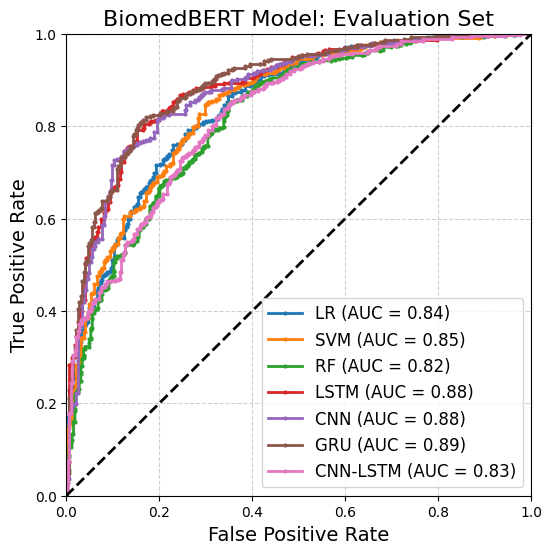

In [35]:
fpr, tpr, _ = roc_curve(unbias_labels, lr_pred_unbias[:,1])
fpr2, tpr2, _ = roc_curve(unbias_labels, svm_pred_unbias[:,1])
fpr3, tpr3, _ = roc_curve(unbias_labels, rf_pred_unbias[:,1])
fpr4, tpr4, _ = roc_curve(unbias_labels, lstm_pred_unbias)
fpr5, tpr5, _ = roc_curve(unbias_labels, cnn_pred_unbias)
fpr6, tpr6, _ = roc_curve(unbias_labels, gru_pred_unbias)
fpr7, tpr7, _ = roc_curve(unbias_labels, lc_pred_unbias)

# Calculate AUC 
roc_auc1 = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)

fprs = [fpr, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7]
tprs = [tpr, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7]
roc_aucs = [roc_auc1, roc_auc2, roc_auc3, roc_auc4, roc_auc5, roc_auc6, roc_auc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))  

for fpr, tpr, roc_auc, label in zip(fprs, tprs, roc_aucs, labels):
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(label, roc_auc), marker='.', markersize=4)  
    
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('BiomedBERT Model: Evaluation Set', fontsize=16)

plt.legend(loc='lower right', fontsize=12)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/roc_curves_unbias.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
#AUPRC curves

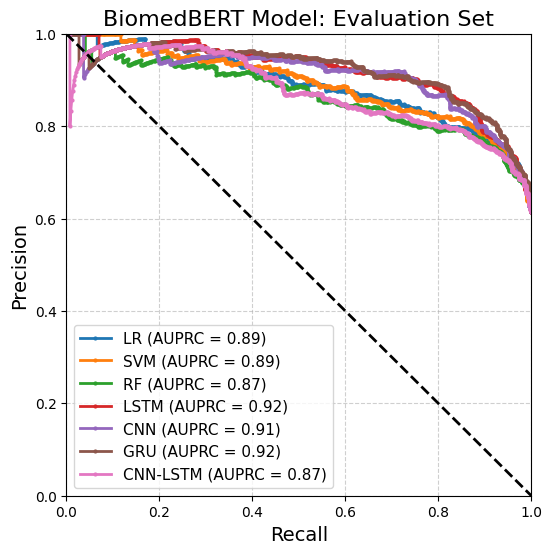

In [37]:
precision1, recall1, _ = precision_recall_curve(unbias_labels, lr_pred_unbias[:,1])
precision2, recall2, _ = precision_recall_curve(unbias_labels, svm_pred_unbias[:, 1])
precision3, recall3, _ = precision_recall_curve(unbias_labels, rf_pred_unbias[:, 1])
precision4, recall4, _ = precision_recall_curve(unbias_labels, lstm_pred_unbias)
precision5, recall5, _ = precision_recall_curve(unbias_labels, cnn_pred_unbias)
precision6, recall6, _ = precision_recall_curve(unbias_labels, gru_pred_unbias)
precision7, recall7, _ = precision_recall_curve(unbias_labels, lc_pred_unbias)

# Calculate AUPRC 
auprc1 = auc(recall1, precision1)
auprc2 = auc(recall2, precision2)
auprc3 = auc(recall3, precision3)
auprc4 = auc(recall4, precision4)
auprc5 = auc(recall5, precision5)
auprc6 = auc(recall6, precision6)
auprc7 = auc(recall7, precision7)

# Store the precision, recall, and AUPRC for each model
precisions = [precision1, precision2, precision3, precision4, precision5, precision6, precision7]
recalls = [recall1, recall2, recall3, recall4, recall5, recall6, recall7]
auprcs = [auprc1, auprc2, auprc3, auprc4, auprc5, auprc6, auprc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

# Plotting AUPRC curves
plt.figure(figsize=(6, 6))

for precision, recall, auprc, label in zip(precisions, recalls, auprcs, labels):
    plt.plot(recall, precision, lw=2, label='{} (AUPRC = {:.2f})'.format(label, auprc), marker='.', markersize=4)

plt.plot([0, 1], [1, 0], color='black', linestyle='--', lw=2)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('BiomedBERT Model: Evaluation Set', fontsize=16)

plt.legend(loc='lower left', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/prc_curves_unbias.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
# Calculate all metrics

In [39]:
dfs = []

algorithm_names = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']
predictions = [np.round(lr_pred_unbias[:,1]), np.round(svm_pred_unbias[:,1]), np.round(rf_pred_unbias[:,1])
               , np.round(lstm_pred_unbias), np.round(cnn_pred_unbias), np.round(gru_pred_unbias), np.round(lc_pred_unbias)]

# Iterate over each algorithm and calculate scores
for name, pred in zip(algorithm_names, predictions):
    conf_matrix = confusion_matrix(unbias_labels, pred)

    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = round(precision, 3)
    recall = round(recall, 3)
    specificity = round(specificity, 3)
    accuracy = round(accuracy, 3)
    f1 = round(f1, 3)

    # Create a DataFrame for each algorithm
    df = pd.DataFrame({
        'Algorithm': [name],
        'Precision': [precision],
        'Recall': [recall],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    })

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
scores_df = pd.concat(dfs, ignore_index=True)
scores_df.to_csv(models_path + '/scores_unbias.csv', index=False, sep='\t')

print(scores_df)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0        LR      0.788   0.875        0.627     0.779     0.829
1       SVM      0.798   0.875        0.649     0.788     0.835
2        RF      0.767   0.900        0.565     0.771     0.828
3      LSTM      0.850   0.855        0.761     0.819     0.853
4       CNN      0.802   0.883        0.655     0.795     0.841
5       GRU      0.829   0.881        0.711     0.815     0.854
6  CNN-LSTM      0.796   0.826        0.665     0.764     0.811


In [40]:
# PLOT LOSSES

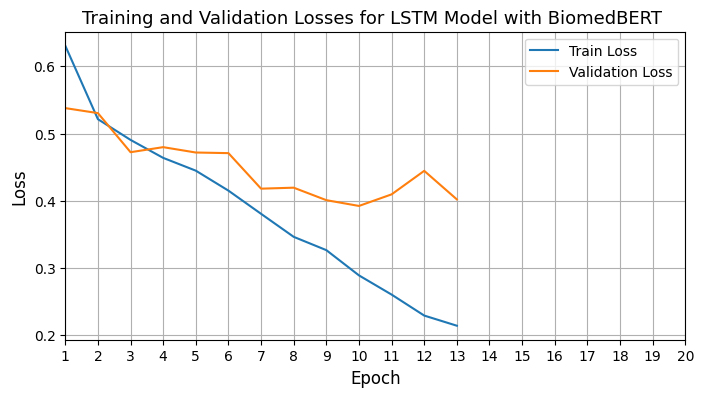

In [41]:
# Load the CSV file
df = pd.read_csv(models_path + "/best_fold_lstm_losses.csv")
# Plot the losses
plt.figure(figsize=(8, 4))

# Plot the training loss
plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

# Plot the validation loss
plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

# Set the x-axis limits
plt.xlim(1, 20)
plt.xticks(range(1, 21))  
plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for LSTM Model with BiomedBERT ", size=13)
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(models_path + "/lstm_loss_plot.png", dpi=300)
plt.show()


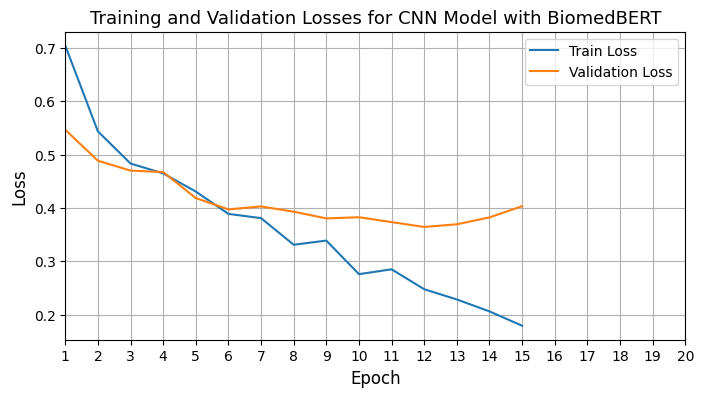

In [42]:
# Load the CSV file
df = pd.read_csv(models_path + "/best_fold_cnn_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 20)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for CNN Model with BiomedBERT", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/cnn_loss_plot.png", dpi=300)
plt.show()


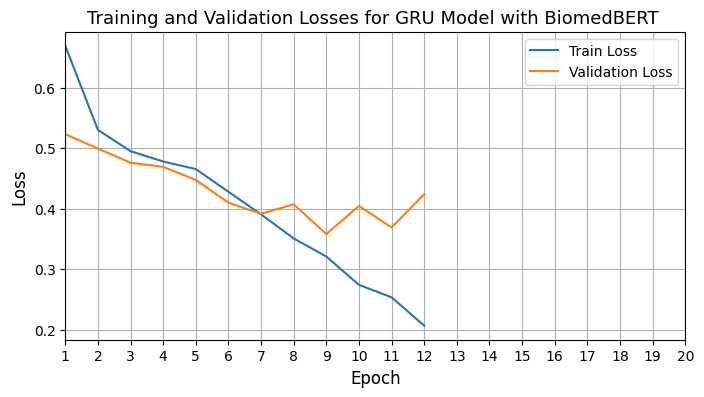

In [43]:
df = pd.read_csv(models_path + "/best_fold_gru_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 20)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for GRU Model with BiomedBERT ", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/gru_loss_plot.png", dpi=300)

plt.show()

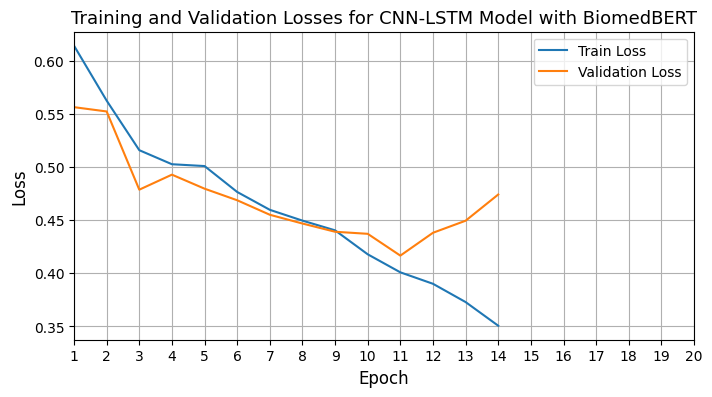

In [44]:
df = pd.read_csv(models_path + "/best_fold_cnn_lstm_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 10)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for CNN-LSTM Model with BiomedBERT", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/cnn_lstm_loss_plot.png", dpi=300)

plt.show()